In [1]:
# Importing necessary libraries
import os
import numpy as np
import cv2
from pathlib import Path
import SimpleITK as sitk
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, shift, rotate, map_coordinates, gaussian_filter
from skimage.transform import resize
import zipfile
import gdown

from tensorflow.keras import layers, models, Input, regularizers, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU

# Ensure TensorFlow is using GPU if available
print(f"Using TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Using TensorFlow version: 2.17.0
Num GPUs Available: 2


In [2]:
main_path = Path.cwd()  # Get the current working directory

# Create the datasets folder if it doesn't exist
if not os.path.exists(main_path / 'datasets'):
    os.mkdir(main_path / 'datasets')

if not os.path.exists(main_path / 'datasets' / 'train') or not os.path.exists(main_path / 'datasets' / 'test'):
    
    # Download the dataset (zip)

    url = 'https://drive.google.com/file/d/1F9LFHyKA00G7aGNpF61D8GWeG54KiEam/view?usp=sharing'

    output = 'datasets/dataset.zip'

    gdown.download(url, output, quiet=False, fuzzy=True)

    # Unzip the dataset inside the datasets folder

    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(main_path / 'datasets')

    print('Dataset unzipped successfully!')
    
    # Remove the zip file
    os.remove(output)
else:
    print('Dataset already exists!')

Downloading...
From (original): https://drive.google.com/uc?id=1F9LFHyKA00G7aGNpF61D8GWeG54KiEam
From (redirected): https://drive.google.com/uc?id=1F9LFHyKA00G7aGNpF61D8GWeG54KiEam&confirm=t&uuid=b65e7aaa-aee4-4a03-8190-b90adf0bbb87
To: /kaggle/working/datasets/dataset.zip
100%|██████████| 536M/536M [00:03<00:00, 167MB/s] 


Dataset unzipped successfully!


In [3]:
def load_mhd_image(image_path):
    """
    Loads a MetaImage (.mhd) file and returns it as a NumPy array.
    
    Args:
        image_path (Path): Path to the .mhd file.
    
    Returns:
        np.ndarray: 3D image array with shape (z, y, x).
    """
    try:
        image_sitk = sitk.ReadImage(str(image_path))
        image_np = sitk.GetArrayFromImage(image_sitk)  # Shape: (z, y, x)
        return image_np
    except Exception as e:
        print(f"[Loader] Error loading image {image_path.name}: {e}")
        return None

def load_mhd_mask(mask_path):
    """
    Loads a MetaImage (.mhd) file for the segmentation mask and returns it as a NumPy array.
    
    Args:
        mask_path (Path): Path to the mask .mhd file.
    
    Returns:
        np.ndarray: 3D mask array with shape (z, y, x), binary (0 and 1).
    """
    try:
        mask_sitk = sitk.ReadImage(str(mask_path))
        mask_np = sitk.GetArrayFromImage(mask_sitk)
        # Binarize the mask in case of any anomalies
        mask_np = (mask_np > 0).astype(np.float32)
        return mask_np
    except Exception as e:
        print(f"[Loader] Error loading mask {mask_path.name}: {e}")
        return None

In [4]:
def visualize_mri_and_mask(image, mask, slice_idx=None):
    """
    Visualizes a single slice of the MRI image and its corresponding mask.
    
    Args:
        image (np.ndarray): 3D MRI image array with shape (z, y, x).
        mask (np.ndarray): 3D mask array with shape (z, y, x).
        slice_idx (int, optional): Specific slice index to visualize. Defaults to the middle slice.
    """
    if slice_idx is None:
        slice_idx = image.shape[0] // 2  # Middle slice
    
    image_slice = image[slice_idx]
    mask_slice = mask[slice_idx]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_slice, cmap='gray')
    plt.title(f'MRI Slice {slice_idx}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask_slice, cmap='gray')
    plt.title(f'Mask Slice {slice_idx}')
    plt.axis('off')
    
    plt.show()

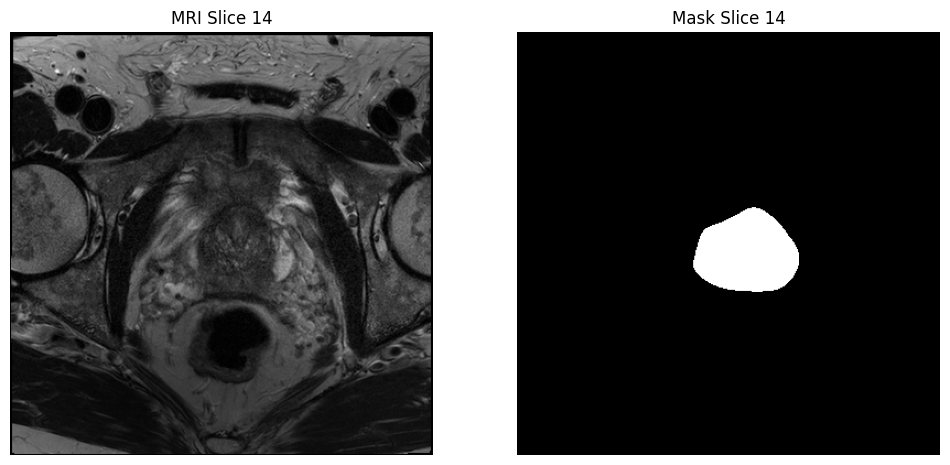

In [7]:
# Define the path to your dataset
data_dir = Path("datasets/train")  # Update this path as needed

# Select an example case
example_case = list(data_dir.glob("Case*.mhd"))[0]  # Select the first case
example_mask = example_case.parent / (example_case.stem + "_segmentation.mhd")

# Load the image and mask
image = load_mhd_image(example_case)
mask = load_mhd_mask(example_mask)

# Visualize the loaded image and mask
visualize_mri_and_mask(image, mask)

In [8]:
def resample_image_and_mask(image_path, mask_path, new_spacing=(1.0, 1.0, 1.0)):
    """
    Resamples the image and mask to the desired voxel spacing.
    
    Args:
        image_path (Path): Path to the MRI .mhd file.
        mask_path (Path): Path to the mask .mhd file.
        new_spacing (tuple): Desired voxel spacing (z, y, x) in mm.
    
    Returns:
        tuple: Resampled image and mask as NumPy arrays.
    """
    try:
        # Read the image and mask using SimpleITK
        image_sitk = sitk.ReadImage(str(image_path))
        mask_sitk = sitk.ReadImage(str(mask_path))
        
        original_spacing = image_sitk.GetSpacing()
        original_size = image_sitk.GetSize()
        #print(f"[Resample] Original spacing: {original_spacing}, size: {original_size}")
    
        # Calculate the new size based on the new spacing
        new_size = [
            int(np.round(original_size[i] * (original_spacing[i] / new_spacing[i])))
            for i in range(3)
        ]
        #print(f"[Resample] New spacing: {new_spacing}, new size: {new_size}")
    
        # Resample image
        resample_image = sitk.Resample(
            image_sitk,
            new_size,
            sitk.Transform(),
            sitk.sitkLinear,
            image_sitk.GetOrigin(),
            new_spacing,
            image_sitk.GetDirection(),
            0,
            image_sitk.GetPixelID()
        )
    
        # Resample mask with nearest neighbor to preserve labels
        resample_mask = sitk.Resample(
            mask_sitk,
            new_size,
            sitk.Transform(),
            sitk.sitkNearestNeighbor,
            mask_sitk.GetOrigin(),
            new_spacing,
            mask_sitk.GetDirection(),
            0,
            mask_sitk.GetPixelID()
        )
    
        # Convert to NumPy arrays
        image_np = sitk.GetArrayFromImage(resample_image).astype(np.float32)
        mask_np = sitk.GetArrayFromImage(resample_mask).astype(np.float32)
        mask_np = (mask_np > 0).astype(np.float32)  # Ensure binary mask
    
        return image_np, mask_np
    except Exception as e:
        print(f"[Resample] Error resampling {image_path.name}: {e}")
        return None, None

In [9]:
def normalize_image(image):
    """
    Normalizes the image to have zero mean and unit variance.
    
    Args:
        image (np.ndarray): 3D image array.
    
    Returns:
        np.ndarray: Normalized image.
    """
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / (std + 1e-8)
    return normalized_image

In [10]:
def preprocess_case_2d(image_path, mask_path, new_spacing=(1.0, 1.0, 1.0)):
    """
    Preprocesses a single case for 2D processing: resampling, normalization, and mask binarization.

    Args:
        image_path (Path): Path to the MRI .mhd file.
        mask_path (Path): Path to the mask .mhd file.
        new_spacing (tuple): Desired voxel spacing (z, y, x) in mm.

    Returns:
        tuple: Preprocessed 3D image and mask as NumPy arrays.
    """
    # Resample the 3D image and mask
    image, mask = resample_image_and_mask(image_path, mask_path, new_spacing=new_spacing)
    if image is None or mask is None:
        return None, None

    # Normalize the image
    image = normalize_image(image)

    return image, mask

In [ ]:
# Preprocess the example case
preprocessed_image, preprocessed_mask = preprocess_case_2d(example_case, example_mask)

# Visualize the preprocessed image and mask
visualize_mri_and_mask(preprocessed_image, preprocessed_mask)

In [ ]:
def extract_slices(image, mask):
    """
    Extracts 2D slices from a 3D image and mask.

    Args:
        image (np.ndarray): 3D image array with shape (z, y, x).
        mask (np.ndarray): 3D mask array with shape (z, y, x).

    Yields:
        tuple: (image_slice, mask_slice) as NumPy arrays.
    """
    z, y, x = image.shape

    for slice_idx in range(z):
        image_slice = image[slice_idx, :, :]
        mask_slice = mask[slice_idx, :, :]

        yield image_slice, mask_slice
        

def calculate_steps(data_dir, dataset_type, patch_depth, patch_size):
    """
    Calculates the total number of patches for a given dataset split.

    Args:
        data_dir (Path): Path to the dataset directory.
        dataset_type (str): 'train' or 'test'.
        patch_depth (int): Number of slices per patch.
        patch_size (tuple): Desired (height, width) of each patch.

    Returns:
        int: Total number of patches.
    """
    case_paths = sorted((data_dir / dataset_type).glob("Case*.mhd"))
    total_patches = 0
    for case_path in case_paths:
        mask_path = case_path.parent / (case_path.stem + "_segmentation.mhd")
        if not mask_path.exists():
            continue
        image, mask = preprocess_case_2d(case_path, mask_path)
        if image is None or mask is None:
            continue
        patches = list(extract_slices(image, mask, patch_depth, patch_size))
        total_patches += len(patches)
    return total_patches

In [13]:
def random_zoom_2d(image, mask, zoom_range=(0.9, 1.1)):
    """
    Applies a random zoom to a 2D image and mask.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        zoom_range (tuple): Tuple specifying the zoom range.

    Returns:
        tuple: Zoomed image and mask.
    """
    # Choose a random zoom factor
    zoom_factor = np.random.uniform(zoom_range[0], zoom_range[1])
    #print(f"[Augmentation] 2D Zoom factor: {zoom_factor}")

    # Apply zoom to image
    image_zoomed = zoom(image, zoom=zoom_factor, order=1, mode='nearest')
    # Apply zoom to mask with nearest interpolation
    mask_zoomed = zoom(mask, zoom=zoom_factor, order=0, mode='nearest')

    # Crop or pad to original shape
    image_zoomed = crop_or_pad_2d(image_zoomed, image.shape)
    mask_zoomed = crop_or_pad_2d(mask_zoomed, mask.shape)

    return image_zoomed, mask_zoomed

def random_shift_2d(image, mask, shift_range=10):
    """
    Applies a random shift to a 2D image and mask.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        shift_range (int): Maximum number of pixels to shift.

    Returns:
        tuple: Shifted image and mask.
    """
    # Generate random shifts for each axis
    shifts = np.random.uniform(-shift_range, shift_range, size=2)
    #print(f"[Augmentation] 2D Shifts: {shifts}")

    # Apply shift to image
    image_shifted = shift(image, shift=shifts, order=1, mode='nearest')
    # Apply shift to mask with nearest interpolation
    mask_shifted = shift(mask, shift=shifts, order=0, mode='nearest')

    return image_shifted, mask_shifted

def elastic_transform_2d(image, mask, alpha=1000, sigma=50):
    """
    Applies an elastic deformation to a 2D image and mask.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        alpha (float): Scaling factor for intensity of deformation.
        sigma (float): Standard deviation for Gaussian filter.

    Returns:
        tuple: Elastically transformed image and mask.
    """
    random_state = np.random.RandomState(None)

    shape = image.shape
    #print(f"[Augmentation] 2D Elastic transform with alpha={alpha}, sigma={sigma}")

    # Generate random displacement fields
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    # Create meshgrid
    y, x = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')

    # Apply displacements
    indices = (y + dy, x + dx)

    # Map coordinates
    image_transformed = map_coordinates(image, indices, order=1, mode='nearest')
    mask_transformed = map_coordinates(mask, indices, order=0, mode='nearest')

    return image_transformed, mask_transformed

def add_gaussian_noise_2d(image, mask, mean=0, std=0.01):
    """
    Adds Gaussian noise to a 2D image.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        mean (float): Mean of the Gaussian noise.
        std (float): Standard deviation of the Gaussian noise.

    Returns:
        tuple: Noisy image and unchanged mask.
    """
    #print(f"[Augmentation] Adding 2D Gaussian noise with mean={mean}, std={std}")
    noise = np.random.normal(mean, std, image.shape)
    image_noisy = image + noise
    image_noisy = np.clip(image_noisy, 0, 1)  # Ensure values are still in [0, 1]
    return image_noisy, mask

def random_rotation_2d(image, mask, angle_range=(-15, 15)):
    """
    Applies a random rotation to a 2D image and mask.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        angle_range (tuple): Range of angles for rotation in degrees.

    Returns:
        tuple: Rotated image and mask.
    """
    angle = np.random.uniform(angle_range[0], angle_range[1])
    #print(f"[Augmentation] 2D Rotation angle: {angle} degrees")

    # Rotate image
    image_rotated = rotate(image, angle, reshape=False, order=1, mode='nearest')
    # Rotate mask with nearest interpolation
    mask_rotated = rotate(mask, angle, reshape=False, order=0, mode='nearest')

    return image_rotated, mask_rotated

def random_flip_2d(image, mask):
    """
    Applies random flipping along horizontal and vertical axes to a 2D image and mask.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.

    Returns:
        tuple: Flipped or unchanged image and mask.
    """
    # Horizontal flip
    if np.random.rand() > 0.5:
        #print(f"[Augmentation] 2D Horizontal flipping")
        image = np.fliplr(image)
        mask = np.fliplr(mask)

    # Vertical flip
    if np.random.rand() > 0.5:
        #print(f"[Augmentation] 2D Vertical flipping")
        image = np.flipud(image)
        mask = np.flipud(mask)

    return image, mask

def crop_or_pad_2d(image, target_shape):
    """
    Crops or pads a 2D image to match the target shape.

    Args:
        image (np.ndarray): 2D image to be resized.
        target_shape (tuple): Desired shape (height, width).

    Returns:
        np.ndarray: Resized image.
    """
    current_shape = image.shape
    padding = []
    cropping = []
    for i in range(2):  # y, x
        if current_shape[i] < target_shape[i]:
            total_pad = target_shape[i] - current_shape[i]
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            padding.append((pad_before, pad_after))
            cropping.append((0, current_shape[i]))
        elif current_shape[i] > target_shape[i]:
            total_crop = current_shape[i] - target_shape[i]
            crop_before = total_crop // 2
            crop_after = crop_before + target_shape[i]
            cropping.append((crop_before, crop_after))
            padding.append((0, 0))
        else:
            cropping.append((0, current_shape[i]))
            padding.append((0, 0))

    # Crop
    y_min, y_max = cropping[0]
    x_min, x_max = cropping[1]
    image_cropped = image[y_min:y_max, x_min:x_max]

    # Pad
    y_pad, x_pad = padding
    image_padded = np.pad(
        image_cropped,
        ((y_pad[0], y_pad[1]),
         (x_pad[0], x_pad[1])),
        mode='constant',
        constant_values=0
    )

    return image_padded


def augment_data_2d(image, mask, augmentations):
    """
    Applies a series of augmentations to a 2D image and mask.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        augmentations (dict): Dictionary specifying which augmentations to apply and their parameters.

    Returns:
        tuple: Augmented image and mask.
    """
    # Random Zoom
    if augmentations.get('zoom', False):
        image, mask = random_zoom_2d(image, mask, zoom_range=augmentations.get('zoom_range', (0.9, 1.1)))

    # Random Shift
    if augmentations.get('shift', False):
        image, mask = random_shift_2d(image, mask, shift_range=augmentations.get('shift_range', 10))

    # Elastic Transformation
    if augmentations.get('elastic', False):
        image, mask = elastic_transform_2d(image, mask,
                                           alpha=augmentations.get('elastic_alpha', 1000),
                                           sigma=augmentations.get('elastic_sigma', 50))

    # Adding Gaussian Noise
    if augmentations.get('noise', False):
        image, mask = add_gaussian_noise_2d(image, mask,
                                           mean=augmentations.get('noise_mean', 0),
                                           std=augmentations.get('noise_std', 0.01))

    # Random Rotation
    if augmentations.get('rotation', False):
        image, mask = random_rotation_2d(image, mask, angle_range=augmentations.get('rotation_range', (-15, 15)))

    # Random Flipping
    if augmentations.get('flip', False):
        image, mask = random_flip_2d(image, mask)

    return image, mask

In [26]:
def dataset_generator_2d(data_dir, batch_size, patch_size=(128, 128), dataset_type='train', augmentations=None):
    """
    A generator to load, preprocess, augment, and output the dataset in batches for 2D processing.

    Args:
        data_dir (Path): Path to the dataset folder with `train` and `test` subfolders.
        batch_size (int): The number of samples per batch.
        patch_size (tuple): Desired (height, width) of each patch.
        dataset_type (str): 'train' or 'test' to determine the dataset split.
        augmentations (dict): Dictionary specifying augmentations to apply.

    Yields:
        tuple: (images, masks) batches.
    """
    # Find all .mhd files for the dataset without segmentation files
    case_paths = sorted((data_dir / dataset_type).glob("Case*.mhd"))
    
    # remove cases
    #print(f"[Generator_2D] Found {len(case_paths)} cases in '{dataset_type}' set.")
    
    while True:  # Infinite loop for generator
        # Shuffle the cases at the beginning of each epoch
        if dataset_type == 'train':
            shuffled_indices = np.random.permutation(len(case_paths))
            print("[Generator_2D] Shuffling data for new epoch.")
        else:
            shuffled_indices = np.arange(len(case_paths))  # No shuffling for validation
    
        image_batch = []
        mask_batch = []
    
        for idx in shuffled_indices:
            case_path = case_paths[idx]
            #print(f"[Generator_2D] Processing {case_path.name}...")
    
            # Construct segmentation path (assuming naming convention)
            
            # If there are no segmentation in the filename
            if("segmentation" not in case_path.stem):
                segmentation_path = case_path.parent / (case_path.stem + "_segmentation.mhd")
            else:
                continue
            #print('\n\n\n\n\n'+segmentation_path+'\n\n\n\n\n')

            #print(f"\n\n\n\n\n\n[Generator_2D] Processing {segmentation_path}...\n\n\n\n\n\n")
            
            # Check if the segmentation file exists
            if not segmentation_path.exists():
                print(f"[Generator_2D] Segmentation file not found for {case_path.name}. Skipping.")
                continue
    
            # Preprocess the image and mask
            image, mask = preprocess_case_2d(case_path, segmentation_path)
            if image is None or mask is None:
                print(f"[Generator_2D] Failed to preprocess data for {case_path.name}. Skipping.")
                continue
    
            # Extract 2D slices from the image and mask
            slice_generator = extract_slices(image, mask)
            num_slices = 0
    
            for image_slice, mask_slice in slice_generator:
                # Apply augmentations if specified and if in training set
                if augmentations and dataset_type == 'train':
                    image_slice, mask_slice = augment_data_2d(image_slice, mask_slice, augmentations)
    
                # Crop or pad the slices to the desired patch size
                image_slice = crop_or_pad_2d(image_slice, patch_size)
                mask_slice = crop_or_pad_2d(mask_slice, patch_size)
    
                # Normalize image
                image_slice = image_slice.astype(np.float32)
                # Already normalized in preprocess_case_2d
    
                # Binarize mask (already done in preprocess_case_2d)
    
                # Add channel dimension
                image_slice = np.expand_dims(image_slice, axis=-1)  # Shape: (height, width, 1)
                mask_slice = np.expand_dims(mask_slice, axis=-1)    # Shape: (height, width, 1)
    
                image_batch.append(image_slice)
                mask_batch.append(mask_slice)
                num_slices += 1
    
                if len(image_batch) == batch_size:
                    #print(f"[Generator_2D] Yielding a batch of {batch_size} samples.")
                    yield np.array(image_batch), np.array(mask_batch)
                    image_batch = []
                    mask_batch = []
    
            #print(f"[Generator_2D] Extracted {num_slices} slices from {case_path.name}.")
    
        # Yield any remaining slices that didn't make a full batch
        if len(image_batch) > 0:
            #print(f"[Generator_2D] Yielding the final batch of {len(image_batch)} samples.")
            yield np.array(image_batch), np.array(mask_batch)
            image_batch = []
            mask_batch = []

In [23]:
def residual_block_2d(input_tensor, filters, dropout_rate=0.2, l2_reg=1e-5):
    """
    Create a residual block for the 2D segmentation model, with a projection shortcut if needed.

    Args:
        input_tensor (tf.Tensor): Input tensor.
        filters (int): Number of filters for the convolutional layers.
        dropout_rate (float): Dropout rate for regularization.
        l2_reg (float): L2 regularization factor.

    Returns:
        tf.Tensor: Output tensor after applying the residual block.
    """
    reg = regularizers.l2(l2_reg)

    # First convolution
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same", kernel_regularizer=reg)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same", kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)

    # Projection shortcut if input and output shapes differ
    if input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, kernel_size=(1, 1), padding="same", kernel_regularizer=reg)(input_tensor)
        input_tensor = layers.BatchNormalization()(input_tensor)

    # Add skip connection
    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)

    # Add dropout
    x = layers.Dropout(dropout_rate)(x)
    return x


def build_residual_2d_unet(input_shape=(128, 128, 1), dropout_rate=0.2, l2_reg=1e-5):
    """
    Build a residual-based 2D U-Net segmentation model.

    Args:
        input_shape (tuple): Shape of the input data (height, width, channels).
        dropout_rate (float): Dropout rate for regularization.
        l2_reg (float): L2 regularization factor.

    Returns:
        tf.keras.Model: Compiled 2D U-Net model.
    """
    inputs = Input(shape=input_shape)
    print(f"[Model_2D] Input shape: {inputs.shape}")

    # Encoder
    c1 = layers.Conv2D(16, kernel_size=(3, 3), padding="same", kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    c1 = residual_block_2d(c1, filters=16, dropout_rate=dropout_rate, l2_reg=l2_reg)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)   # (64x64x16)

    c2 = residual_block_2d(p1, filters=32, dropout_rate=dropout_rate, l2_reg=l2_reg)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)   # (32x32x32)

    c3 = residual_block_2d(p2, filters=64, dropout_rate=dropout_rate, l2_reg=l2_reg)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)   # (16x16x64)

    # Bottleneck
    c4 = residual_block_2d(p3, filters=128, dropout_rate=dropout_rate, l2_reg=l2_reg)
    print(f"[Model_2D] Bottleneck shape: {c4.shape}")

    # Decoder
    u3 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(c4)
    u3 = layers.concatenate([u3, c3])
    c5 = residual_block_2d(u3, filters=64, dropout_rate=dropout_rate, l2_reg=l2_reg) # (32x32x64)

    u2 = layers.Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding="same")(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = residual_block_2d(u2, filters=32, dropout_rate=dropout_rate, l2_reg=l2_reg) # (64x64x32)

    u1 = layers.Conv2DTranspose(16, kernel_size=(2, 2), strides=(2, 2), padding="same")(c6)
    u1 = layers.concatenate([u1, c1])
    c7 = residual_block_2d(u1, filters=16, dropout_rate=dropout_rate, l2_reg=l2_reg) # (128x128x16)

    # Output layer
    outputs = layers.Conv2D(1, kernel_size=(1, 1), activation="sigmoid")(c7)
    print(f"[Model_2D] Output shape: {outputs.shape}")

    model = models.Model(inputs, outputs)
    return model

In [16]:
def count_cases(data_dir, dataset_type):
    """
    Count the number of cases in the dataset.

    Args:
        data_dir (Path): Path to the dataset directory.
        dataset_type (str): 'train' or 'test'.

    Returns:
        int: Number of cases.
    """
    num_cases = len(list((data_dir / dataset_type).glob("Case*.mhd")))
    #print(f"[Info] Number of {dataset_type} cases: {num_cases}")
    return num_cases

[Main] Train folder path: datasets/train
[Main] Test folder path: datasets/test
[Generator_2D] Shuffling data for new epoch.
[Main] Batch 1 - Sample images shape: (2, 128, 128, 1)
[Main] Batch 1 - Sample masks shape: (2, 128, 128, 1)


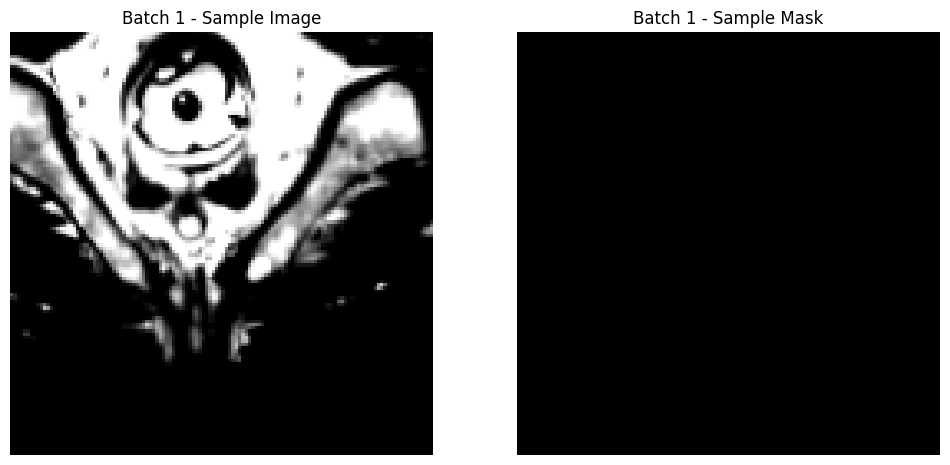

[Main] Batch 2 - Sample images shape: (2, 128, 128, 1)
[Main] Batch 2 - Sample masks shape: (2, 128, 128, 1)


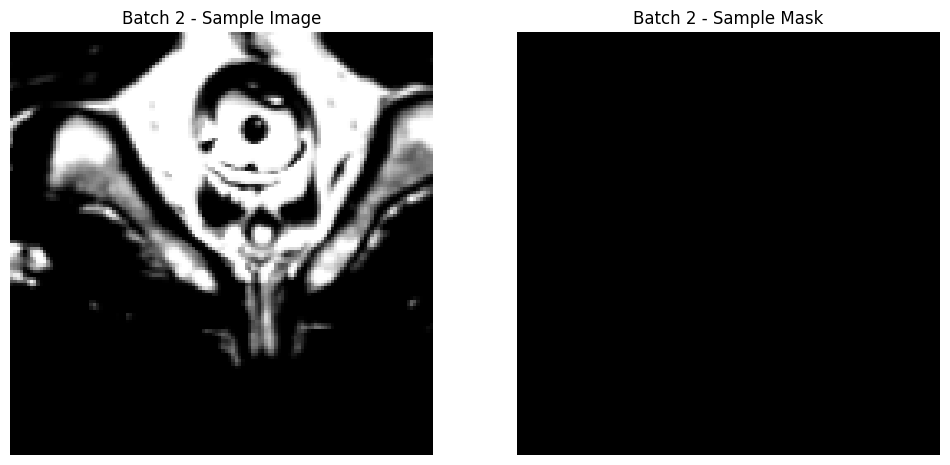

[Main] Batch 3 - Sample images shape: (2, 128, 128, 1)
[Main] Batch 3 - Sample masks shape: (2, 128, 128, 1)


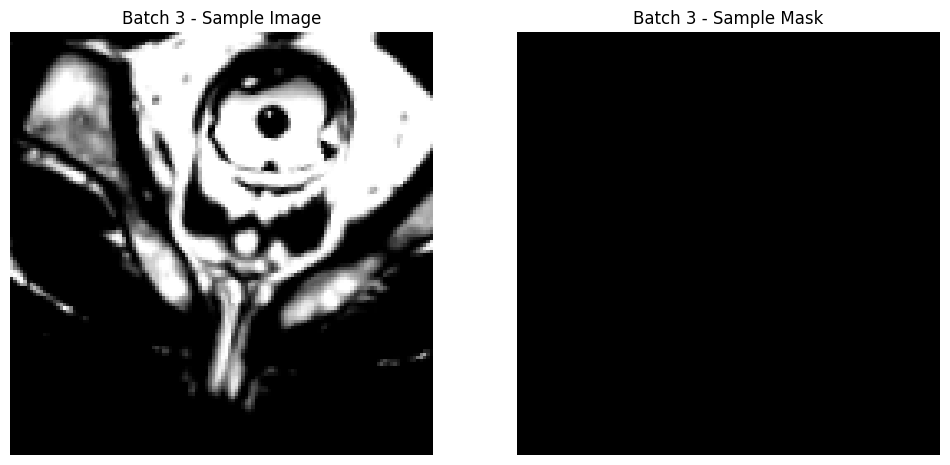

[Main] Batch 4 - Sample images shape: (2, 128, 128, 1)
[Main] Batch 4 - Sample masks shape: (2, 128, 128, 1)


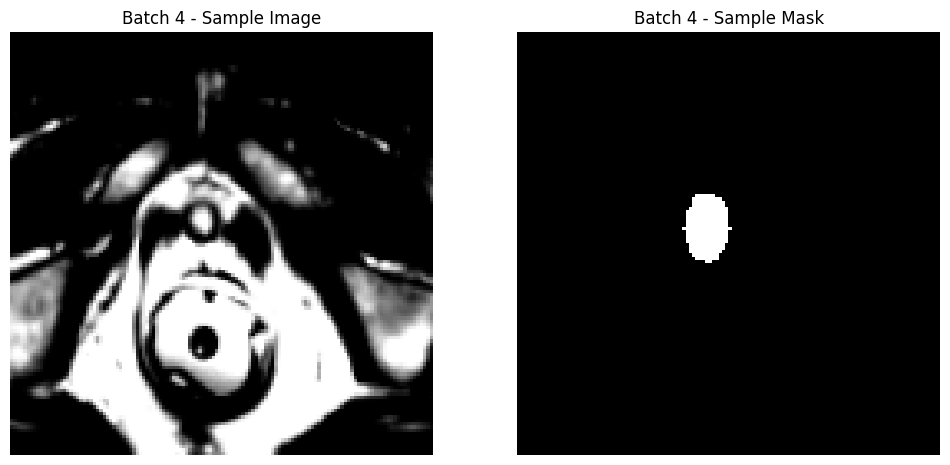

[Main] Batch 5 - Sample images shape: (2, 128, 128, 1)
[Main] Batch 5 - Sample masks shape: (2, 128, 128, 1)


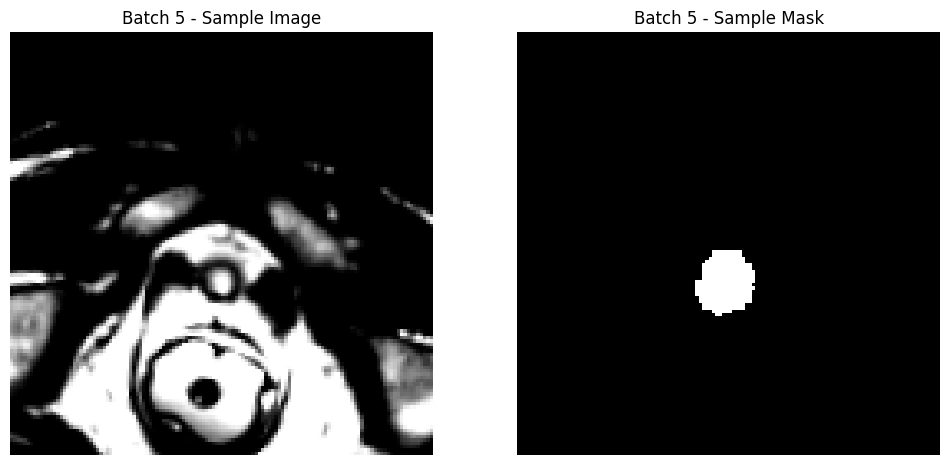

In [24]:
"""
Main function to define the model, prepare data generators, train the model, evaluate, and visualize predictions.
"""
# Paths and parameters
data_dir = Path("datasets")  # Update this path as needed
train_data_dir = data_dir / "train"
test_data_dir = data_dir / "test"
batch_size = 2
patch_depth = 8
patch_size = (128, 128)
input_shape = (patch_size[0], patch_size[1], 1)
epochs = 50  # Adjust as needed
patience = 10  # For EarlyStopping
print(f"[Main] Train folder path: {train_data_dir}")
print(f"[Main] Test folder path: {test_data_dir}")
# Verify dataset directories exist
if not train_data_dir.exists():
    print(f"[Error] Training directory '{train_data_dir}' does not exist.")
    exit()
if not test_data_dir.exists():
    print(f"[Error] Testing directory '{test_data_dir}' does not exist.")
    exit()
# Define augmentation parameters
augmentations = {
    'zoom': True,
    'zoom_range': (0.9, 1.1),
    'shift': True,
    'shift_range': 10,
    'elastic': True,
    'elastic_alpha': 1000,
    'elastic_sigma': 50,
    'noise': True,
    'noise_mean': 0,
    'noise_std': 0.01,
    'rotation': True,
    'rotation_range': (-15, 15),
    'flip': True
}
# Initialize 2D generators
train_generator = dataset_generator_2d(
    data_dir=data_dir,
    batch_size=batch_size,
    patch_size=patch_size,
    dataset_type="train",
    augmentations=augmentations
)
val_generator = dataset_generator_2d(
    data_dir=data_dir,
    batch_size=batch_size,
    patch_size=patch_size,
    dataset_type="test",
    augmentations=None  # Typically, no augmentation for validation
)

# Count cases
num_train_cases = count_cases(data_dir, 'train')
num_val_cases = count_cases(data_dir, 'test')

# Visualize the first 5 batches of data
for i in range(5):
    sample_images, sample_masks = next(train_generator)
    print(f"[Main] Batch {i+1} - Sample images shape: {sample_images.shape}")
    print(f"[Main] Batch {i+1} - Sample masks shape: {sample_masks.shape}")
    
    # Visualize the first sample in the batch
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_images[0, :, :, 0], cmap='gray')
    plt.title(f"Batch {i+1} - Sample Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(sample_masks[0, :, :, 0], cmap='gray')
    plt.title(f"Batch {i+1} - Sample Mask")
    plt.axis('off')
    
    plt.show()

In [18]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Computes the Dice Coefficient.

    Args:
        y_true (tf.Tensor): Ground truth masks.
        y_pred (tf.Tensor): Predicted masks.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        tf.Tensor: Dice coefficient.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """
    Computes the Dice Loss.

    Args:
        y_true (tf.Tensor): Ground truth masks.
        y_pred (tf.Tensor): Predicted masks.

    Returns:
        tf.Tensor: Dice loss.
    """
    return 1 - dice_coefficient(y_true, y_pred)

In [25]:

# Estimate number of steps per epoch
# For precise calculation, determine the total number of patches per epoch
# Here, we'll set steps_per_epoch and validation_steps to fixed numbers
steps_per_epoch = 100  # Adjust based on your dataset
validation_steps = 20  # Adjust based on your dataset

# Build the 2D model
model = build_residual_2d_unet(input_shape=input_shape, dropout_rate=0.2, l2_reg=1e-5)
model.summary()

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=[dice_coefficient, 'accuracy', MeanIoU(num_classes=2)]
)
print("[Main] 2D Model compiled successfully.")


# Define callbacks
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='val_dice_coefficient',
    mode='max',
    save_best_only=True,
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_dice_coefficient',
    patience=patience,
    mode='max',
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    mode='min',
    min_lr=1e-6
)
callbacks = [checkpoint, early_stop, reduce_lr]

[Model_2D] Input shape: (None, 128, 128, 1)
[Model_2D] Bottleneck shape: (None, 16, 16, 128)
[Model_2D] Output shape: (None, 128, 128, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 16)   │            160 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 128, 128, 16)   │             64 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_14 (ReLU)           │ (None, 128, 128, 16)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ re_lu_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 128, 128, 16)   │             64 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_15 (ReLU)           │ (None, 128, 128, 16)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ re_lu_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 128, 128, 16)   │             64 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 128, 128, 16)   │              0 │ batch_normalization_2… │
│                           │                        │                │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_16 (ReLU)           │ (None, 128, 128, 16)   │              0 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128, 128, 16)   │              0 │ re_lu_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 64, 64, 16)     │              0 │ dropout_7[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 64, 64, 32)     │            128 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 756,049 (2.88 MB)

 Trainable params: 753,265 (2.87 MB)

 Non-trainable params: 2,784 (10.88 KB)

[Main] 2D Model compiled successfully.


In [27]:

# Train the model
print("[Main] Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)
print("[Main] Training completed.")
# Save the final model
model.save("final_model.keras")
print("[Main] Final model saved as 'final_model.keras'.")

[Main] Starting training...
Epoch 1/50
 37/100 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9000 - dice_coefficient: 0.1011 - loss: 0.9121 - mean_io_u_1: 0.4588[Generator_2D] Extracted 86 slices from Case42.mhd.
 88/100 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9007 - dice_coefficient: 0.0994 - loss: 0.9138 - mean_io_u_1: 0.4628[Generator_2D] Extracted 101 slices from Case12.mhd.
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9017 - dice_coefficient: 0.0960 - loss: 0.9171 - mean_io_u_1: 0.4644
Epoch 1: val_dice_coefficient improved from -inf to 0.12767, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.9018 - dice_coefficient: 0.0957 - loss: 0.9174 - mean_io_u_1: 0.4645 - val_accuracy: 0.9047 - val_dice_coefficient: 0.1277 - val_loss: 0.8855 - val_mean_io_u_1: 0.4523 - learning_rate: 1.0000e-04
Epoch 2/50
 24/100 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.8896 - dice_coefficient: 0.1316 - loss: 0.8815 - mean_io_u_1: 0.47

In [21]:
# Evaluation and Visualization functions have been defined earlier.

def evaluate_model(model, val_generator, validation_steps):
    """
    Evaluates the model on the validation set.

    Args:
        model (tf.keras.Model): Trained model.
        val_generator (generator): Validation data generator.
        validation_steps (int): Number of validation steps.

    Returns:
        dict: Evaluation metrics.
    """
    print("[Evaluation] Starting evaluation on validation set...")
    results = model.evaluate(val_generator, steps=validation_steps, verbose=1)
    for name, value in zip(model.metrics_names, results):
        print(f"[Evaluation] {name}: {value:.4f}")
    return dict(zip(model.metrics_names, results))

def visualize_predictions(model, val_generator, num_batches=1, num_samples=2):
    """
    Visualizes predictions on the validation set.

    Args:
        model (tf.keras.Model): Trained model.
        val_generator (generator): Validation data generator.
        num_batches (int): Number of batches to visualize.
        num_samples (int): Number of samples per batch to visualize.
    """
    print("[Visualization] Starting visualization of predictions...")
    for batch_num in range(num_batches):
        print(f"\n[Visualization] Fetching batch {batch_num + 1} from validation generator...")
        images, masks = next(val_generator)
        print(f"[Visualization] Batch {batch_num + 1} - Images shape: {images.shape}, Masks shape: {masks.shape}")

        # Predict masks
        preds = model.predict(images)
        preds_binary = (preds > 0.5).astype(np.float32)

        # Visualize
        visualize_batch_2d(images, masks, predictions=preds_binary, num_samples=num_samples)

# Define the visualize_batch function if not already defined
def visualize_batch_2d(images, masks, predictions=None, num_samples=2):
    """
    Visualizes samples from a batch of 2D images and masks, and optionally predictions.

    Args:
        images (np.ndarray): Batch of images with shape (batch_size, height, width, 1).
        masks (np.ndarray): Batch of masks with shape (batch_size, height, width, 1).
        predictions (np.ndarray, optional): Batch of predicted masks with the same shape as masks.
        num_samples (int): Number of samples to visualize from the batch.
    """
    batch_size = images.shape[0]
    num_samples = min(num_samples, batch_size)
    
    for i in range(num_samples):
        image = images[i, :, :, 0]  # Shape: (height, width)
        mask = masks[i, :, :, 0]    # Shape: (height, width)
        if predictions is not None:
            pred = predictions[i, :, :, 0]  # Shape: (height, width)

        # Select the center slice (for 2D, this is the only slice)
        # Alternatively, implement logic to select specific slices if needed

        # Create a figure with subplots
        if predictions is not None:
            num_plots = 4  # MRI, Ground Truth, Prediction, Overlay, Difference
        else:
            num_plots = 2  # MRI and Ground Truth

        plt.figure(figsize=(24, 6))

        # MRI Image
        plt.subplot(1, num_plots, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Sample {i+1} - MRI Image')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(1, num_plots, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Sample {i+1} - Ground Truth')
        plt.axis('off')

        if predictions is not None:
            # Predicted Mask
            plt.subplot(1, num_plots, 3)
            plt.imshow(pred, cmap='gray')
            plt.title(f'Sample {i+1} - Prediction')
            plt.axis('off')

            # Overlay of Prediction on MRI
            plt.subplot(1, num_plots, 4)
            plt.imshow(image, cmap='gray')
            plt.imshow(pred, cmap='jet', alpha=0.5)
            plt.title(f'Sample {i+1} - Prediction Overlay')
            plt.axis('off')

            # Optionally, add a difference map
            # Uncomment the following lines if you want to include it
            # difference = np.abs(mask - pred)
            # plt.figure(figsize=(6, 6))
            # plt.imshow(image, cmap='gray')
            # plt.imshow(difference, cmap='Reds', alpha=0.5)
            # plt.title(f'Sample {i+1} - Prediction Difference')
            # plt.axis('off')
            # plt.show()

        plt.tight_layout()
        plt.show()

[Evaluation] Starting evaluation on validation set...
 1/20 ━━━━━━━━━━━━━━━━━━━━ 1:04 3s/step - accuracy: 0.7035 - dice_coefficient: 1.0259e-10 - loss: 1.0132 - mean_io_u_1: 0.4826[Generator_2D] Extracted 95 slices from Case09.mhd.
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7467 - dice_coefficient: 0.0214 - loss: 0.9918 - mean_io_u_1: 0.4880  
[Evaluation] loss: 0.9520
[Evaluation] compile_metrics: 0.0612
[Final Evaluation Metrics] {'loss': 0.9519879221916199, 'compile_metrics': 0.06119122356176376}
[Visualization] Starting visualization of predictions...

[Visualization] Fetching batch 1 from validation generator...
[Visualization] Batch 1 - Images shape: (2, 128, 128, 1), Masks shape: (2, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


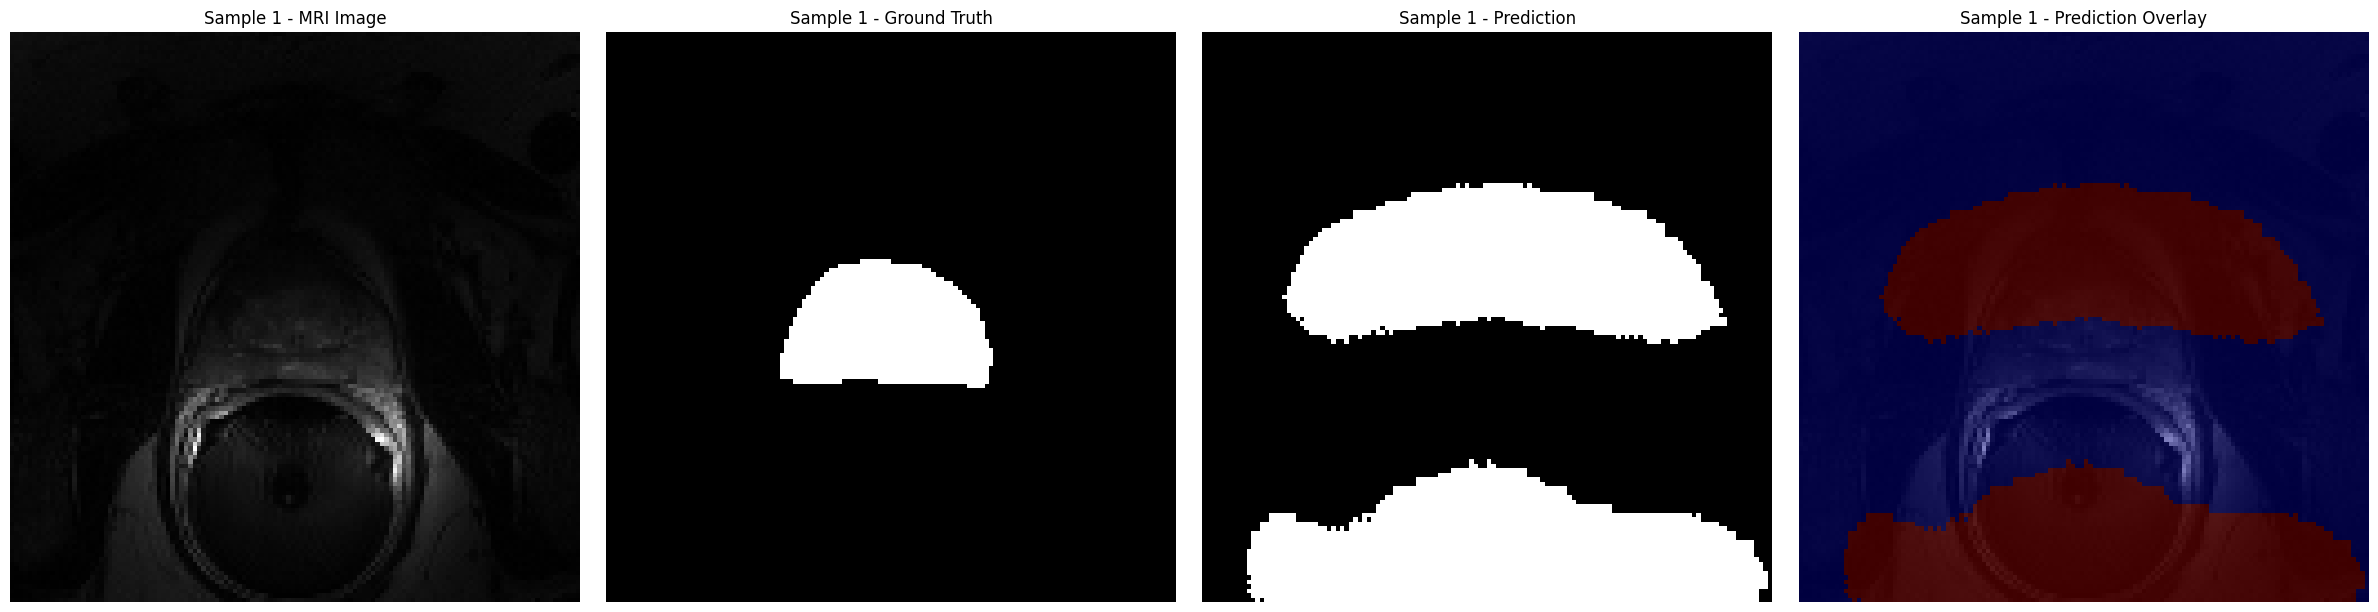

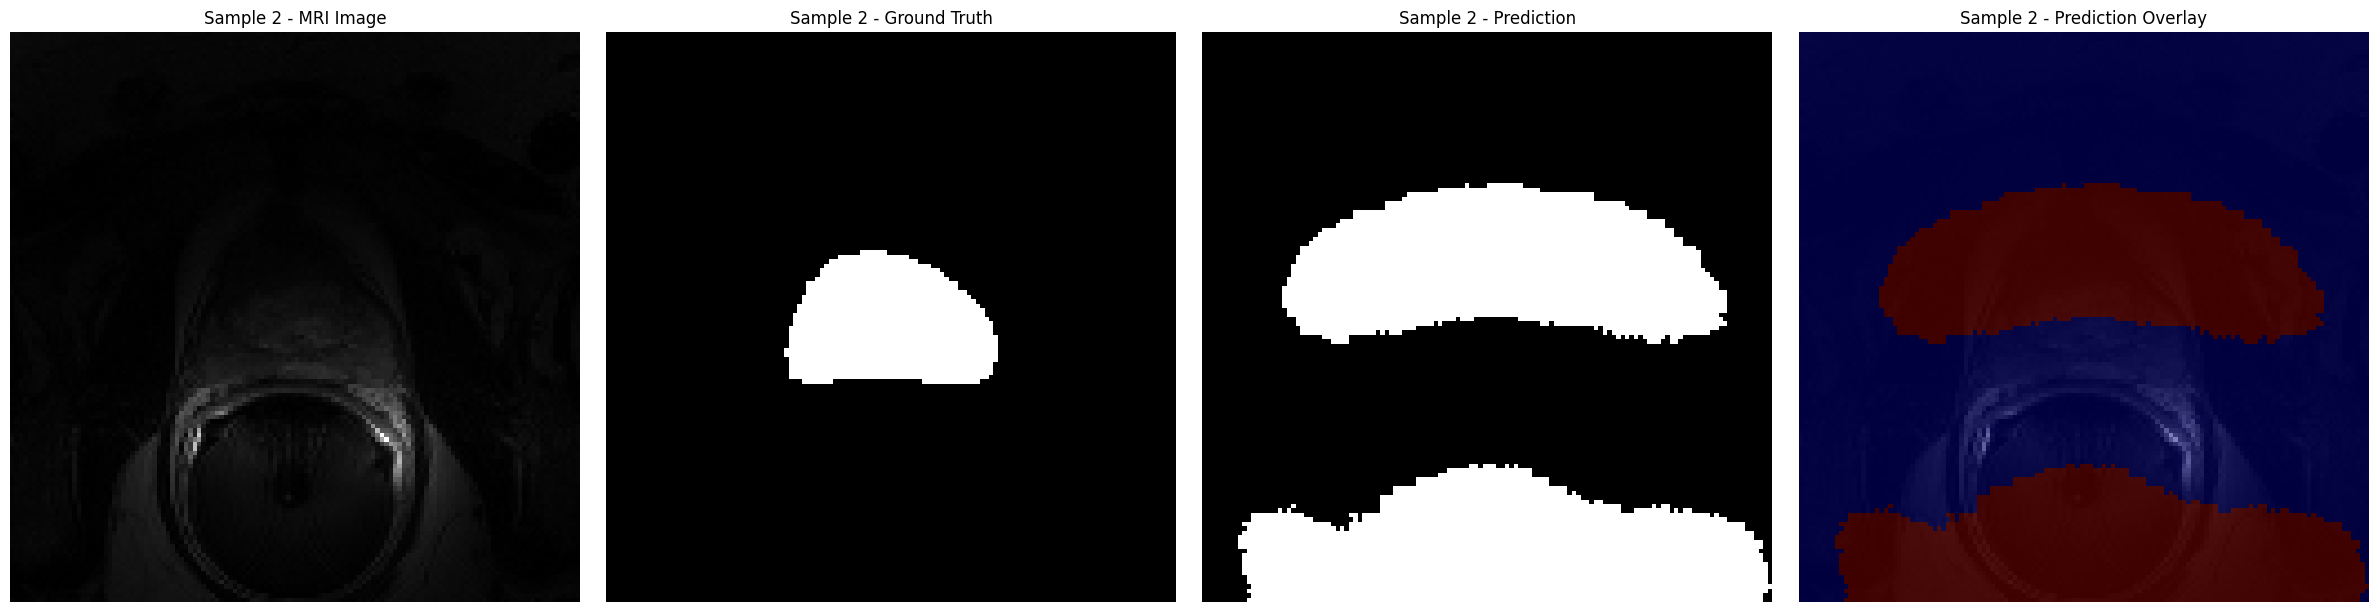


[Visualization] Fetching batch 2 from validation generator...
[Visualization] Batch 2 - Images shape: (2, 128, 128, 1), Masks shape: (2, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


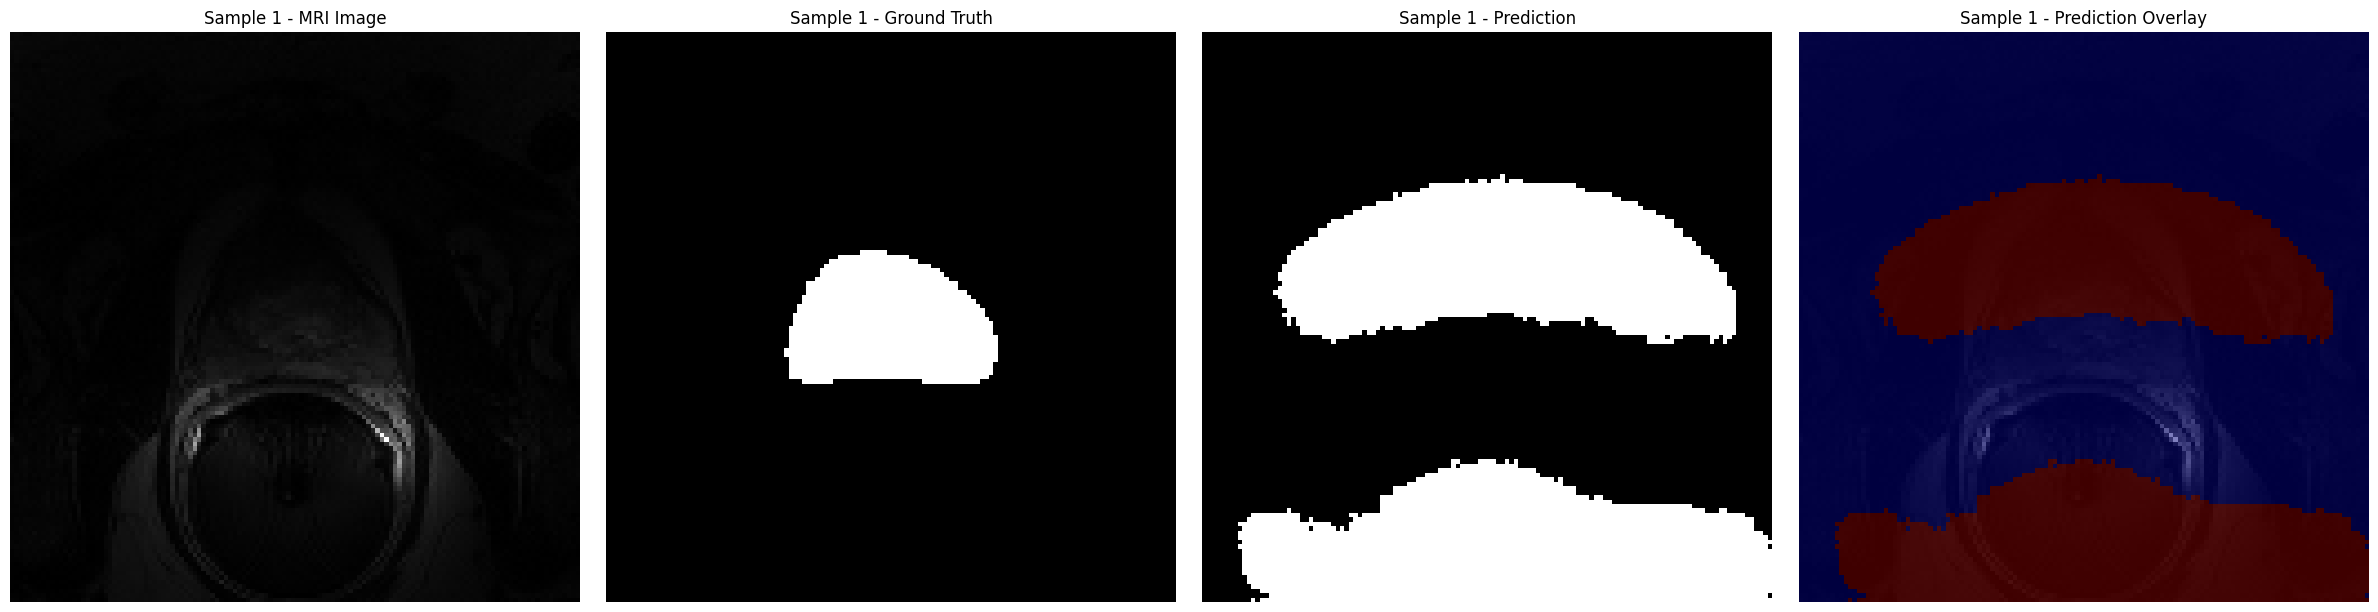

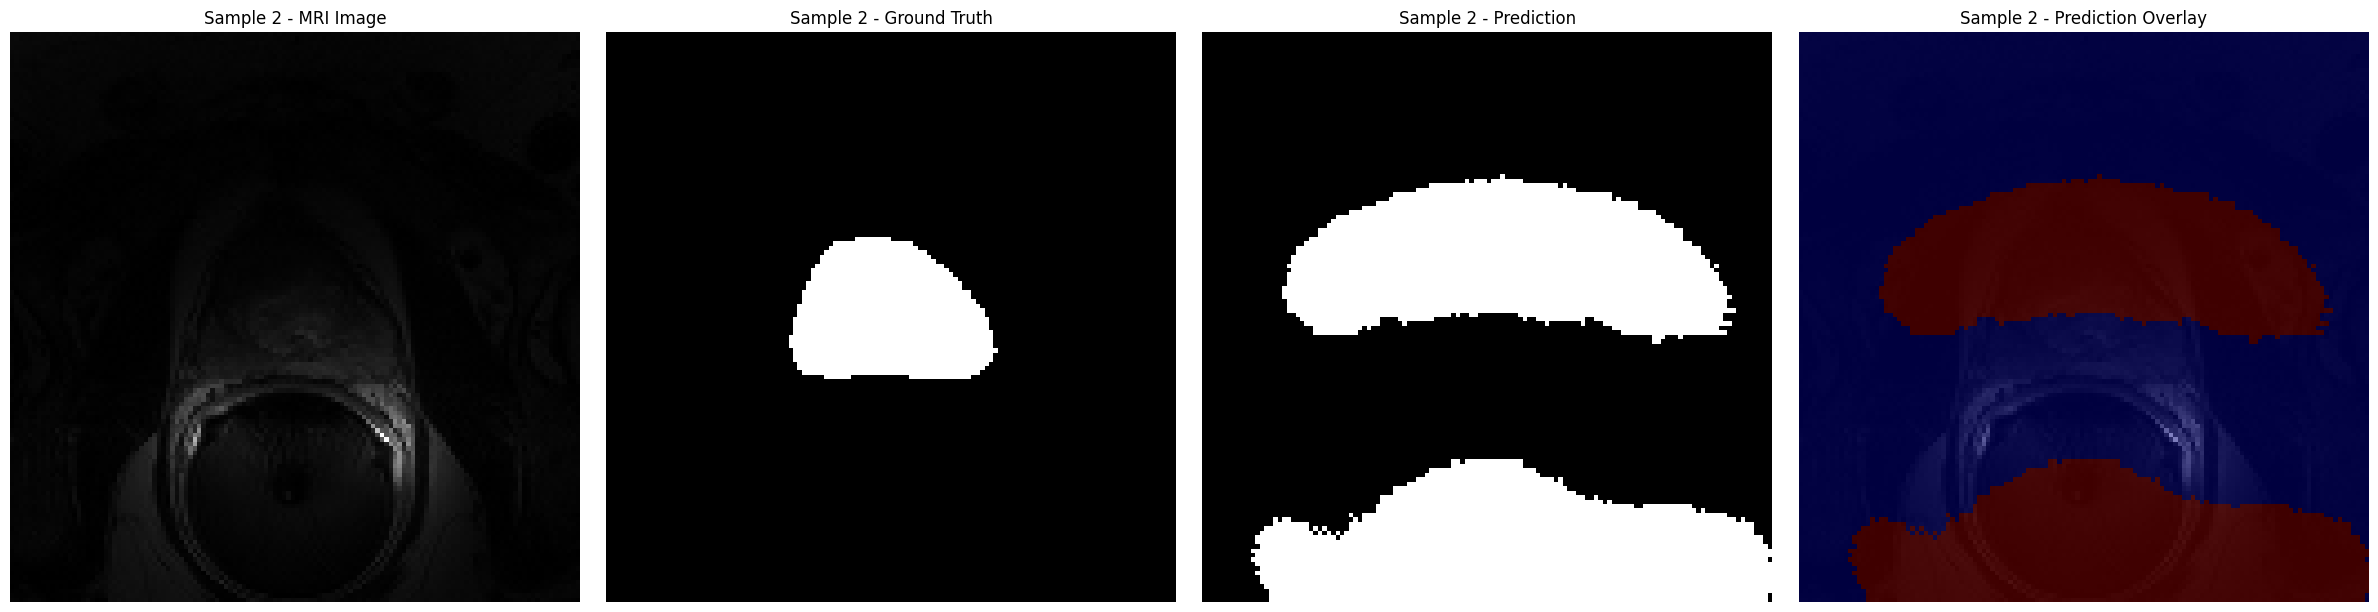

In [29]:
# Assuming the main() function has been executed and the model has been trained.

# Load the best model
from tensorflow.keras.models import load_model

model = load_model("best_model.keras", custom_objects={'dice_loss': dice_loss, 'dice_coefficient': dice_coefficient})

# Evaluate the model
evaluation_metrics = evaluate_model(model, val_generator, validation_steps)
print("[Final Evaluation Metrics]", evaluation_metrics)

# Visualize predictions
visualize_predictions(model, val_generator, num_batches=2, num_samples=2)